In [6]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

import yaml

import utilities as u


import itertools

In [7]:
from pixell import enmap, utils as putils

In [33]:
values_file = 'configurations/configILC.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [34]:


plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [35]:
C = u.Converting()

In [36]:
lmax_fixed = 3500

In [37]:
changemap = lambda x: enmap.enmap(x, wcs)
mapsObjA = u.mapNamesObj(nu)
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft, lmax = lmax_fixed)

In [38]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)
field_names_A = ['ilc', 'ilcdepr']

In [39]:
lmin_A, lmax_A = 30, 3500
Lmin, Lmax = 10, 6000

In [40]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 6000, deltal = 30, log = False, nBins = 20)

In [41]:
lmaxes_configs[0]

(3000, 3000, 2500, 3000, 3000)

In [42]:
lmaxes_dict = {}
lmax_directory = ''

noise_dict = {}

for e_index, e in enumerate(estimators):
    l = lmax_fixed #lmaxes[e_index]
    lmaxes_dict[e] = l
    lmax_directory += f'{names[e]}{l}'
    hardening = estimators_dictionary[e]['hardening']
    
    hardening_A = estimators_dictionary[e]['hardening']
    hardening_B = estimators_dictionary[e]['hardening']
    
    estimator_to_harden_A = 'hu_ok' if (e in ['bh', 'pbh']) else e
    estimator_to_harden_B = 'hu_ok' if (e in ['bh', 'pbh']) else e
    
    field_names_A = estimators_dictionary[e]['field_names']
    tszprofileA = estimators_dictionary[e]['tszprofile']
    tszprofileB = estimators_dictionary[e]['tszprofile']
    tszprofile_A = None if tszprofileA == '' else 1.
    tszprofile_B = None if tszprofileB == '' else 1.
    
    estimator_to_harden_A = 'symm' if ('symm' in e) else estimator_to_harden_A 
    estimator_to_harden_B = 'symm' if ('symm' in e) else estimator_to_harden_B
    
    feed_dict = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A, field_names_A, modlmap, 
                                hardening_A, hardening_B, tszprofile_A, tszprofile_B)
    
    
    A = u.Estimator(shape, wcs, feed_dict, e, lmin_A, lmax_A,
                                    field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, estimator_to_harden = estimator_to_harden_A, XY = 'TT')
    
    NAB_cross = A.get_Nl_cross(A)
    el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
    noise_dict[e] = NAB_cross_binned

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:301: RuntimeWarning: overflow encountered in multiply
  val += ot2d*ffft
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: invalid value encountered in multiply
  return val * mul
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:475: RuntimeWarning: invalid value encountered in true_divide
  w_E1_E2 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:476: RuntimeWarning: invalid value encountered in true_divide
  w_E2_E1 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:488: RuntimeWarning: invalid value encountered in true_divide
  coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_

In [65]:
feed_dict['pcsrc_T_T'] = 1

In [66]:
f, F, Fr = A.get_mc_expressions('symmbh', hardening = 'src', field_names = field_names_A, wcs = wcs, shape = shape, feed_dict=feed_dict,
                    xmask = A.get_mask(shape, wcs, lmin_A, lmax_A, 0, 0), ymask = A.get_mask(shape, wcs, lmin_A, lmax_A, 0, 0))

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:301: RuntimeWarning: overflow encountered in multiply
  val += ot2d*ffft
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: invalid value encountered in multiply
  return val * mul


In [67]:
F

(uC_T_T_l1*(Lx*l1x + Ly*l1y) + uC_T_T_l2*(Lx*l2x + Ly*l2y) - Asrc_src_L*pcsrc_T_T_l1*pcsrc_T_T_l2/Aphi_src_L)/(2*tC_ilc_T_ilc_T_l1*tC_ilcdepr_T_ilcdepr_T_l2)

In [54]:
f_phiA, F_phiA, Fr_phiA = A.get_mc_expressions('hdv', field_names = field_names_A)

In [60]:
fs, Fs, _ = A.get_mc_expressions('src', field_names = field_names_A)

In [61]:
Fs

pcsrc_T_T_l1*pcsrc_T_T_l2/(2*tC_ilc_T_ilc_T_l1*tC_ilcdepr_T_ilcdepr_T_l2)

In [43]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']
    
colors_ests['kk'] = 'black'
colors_ests['kg'] = 'yellow'

labels_ests['kk'] = 'Signal'
labels_ests['kg'] = 'Cross signal'

In [44]:
P = PP/'s4000b4500sy4500p3000/'

getoutname = lambda key: f'{key}_{nu}.npy'

ells = np.load(P/getoutname('ells'))
kk = np.load(P/getoutname('kk'))
kg = np.load(P/getoutname('kg'))
gg = np.load(P/getoutname('gg'))

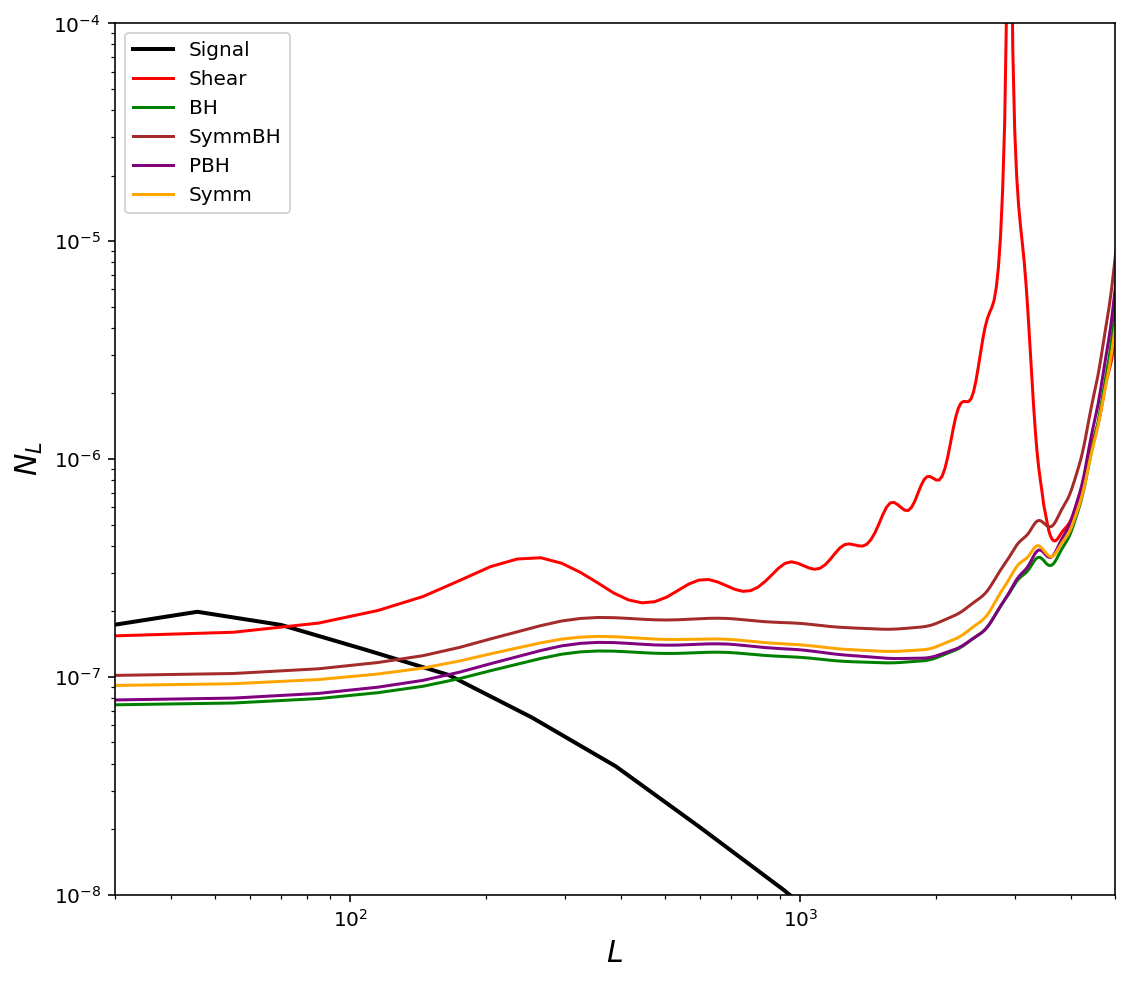

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (8, 7))
ax.plot(ells, kk, color = colors_ests['kk'], lw = 2, label = labels_ests['kk'])

for e_index, e in enumerate(estimators):
    ax.plot(el, noise_dict[e], color = colors_ests[e], label = labels_ests[e])
    
#for e_index, e in enumerate(estimators):
#    ax.plot(ells, noises[e_index, e_index], color = colors_ests[e], label = labels_ests[e])
    
    
    
ax.set_ylabel('$N_L$', size = 15)
ax.set_xlabel('$L$', size = 15)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(30, 5000)
ax.set_ylim(1e-8, 1e-4)

ax.legend()

fig.tight_layout()

plt.show()

In [36]:
p = pathlib.Path('output1102')
pilc = pathlib.Path('output_ILC_1102')

In [40]:
path = p/'h3500s3500b3500'/'tsz/'
pathILC = pilc/'h3500s3500b3500sy3500'/'tsz/'

In [41]:
T = np.load(path/'T_tsz_148.npy')
Tilc = np.load(pathILC/'T_tsz_ilc.npy')
kk = np.load(path/'kk_tsz_148.npy')
ells = np.load(path/'ells_tsz_148.npy')

### What happens if you just do a simple rescaling?

i.e. Q[Tnu0, Tnu0] -> Q[Tnu0, Tnu0]*(nu*nu)/(nu0*nu0)

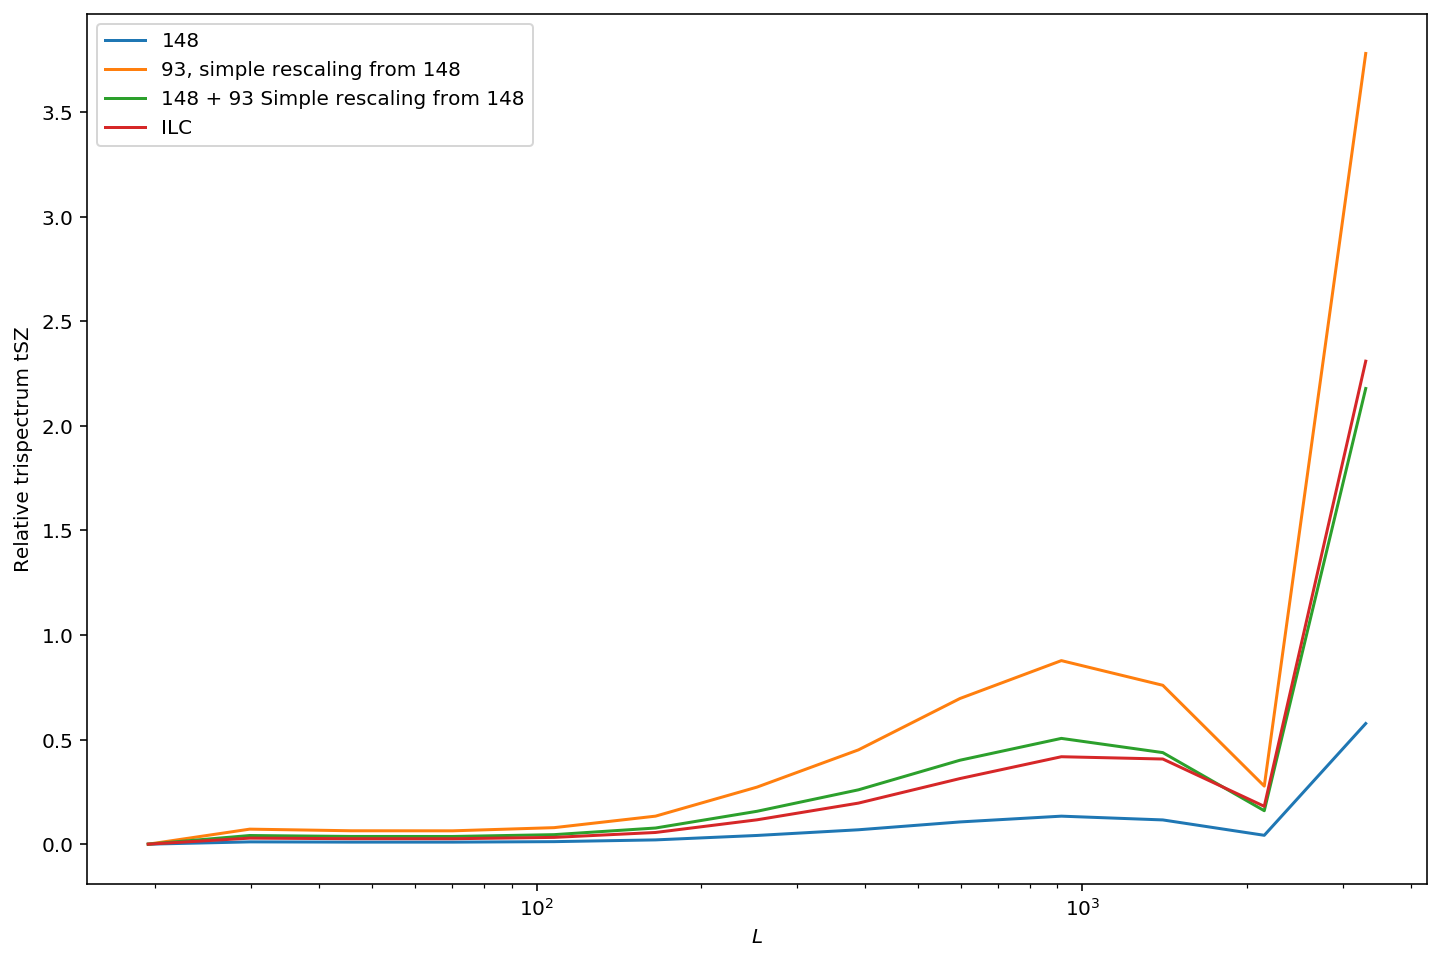

In [44]:
plt.plot(ells, T[0, 0]/kk, label = '148')
plt.plot(ells, T[0, 0]/kk*1.6**4, label = '93, simple rescaling from 148')

plt.plot(ells, 0.5*(T[0, 0]/kk+T[0, 0]/kk*1.6**4), label = '148 + 93 Simple rescaling from 148')

plt.plot(ells, Tilc[0, 0]/kk, label = 'ILC')
plt.xscale('log')
plt.xlabel('$L$')
plt.ylabel('Relative trispectrum tSZ')
plt.legend()

### Try with simple estimator for one single cutout sim

In [110]:
import utilities as u
from pixell import enmap, utils as putils
from scipy.interpolate import interp1d

In [65]:
lmin_A = 30
Lmin, Lmax = 20, 6000

In [66]:
nuA = 148

In [67]:
mapsObjA = u.mapNamesObj(nuA)

In [68]:
hardening_A = None

In [69]:
changemap = lambda x: enmap.enmap(x, wcs)

In [70]:
C = u.Converting()

In [71]:
spectra_path = 'input_spectra/'
sims_directory = '../extract_sehgal/manusmaps/flat_maps_large/newmaps11022021/148/'
WR = u.write_read(sims_directory)

In [72]:
lmax_A = 3500
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft, lmax = lmax_A)

In [73]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)

In [74]:
field_names_A = ['X', 'Y']

In [75]:
feed_dict = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A, field_names_A, modlmap)

In [79]:
field_names_A_ilc = ['ilc', 'ilc']
feed_dict_ilc = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A_ilc, field_names_A_ilc, modlmap)

In [85]:
estA = 'hu_ok'

In [90]:
A = u.Estimator(shape, wcs, feed_dict, estA, lmin_A, lmax_A,
                                    field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, XY = 'TT')


Ailc = u.Estimator(shape, wcs, feed_dict_ilc, estA, lmin_A, lmax_A,
                                    field_names = field_names_A_ilc, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, XY = 'TT')

In [78]:
i = 0
fgnamefile = 'tsz'
cmb0_fft, cmb1_fft, fg_fft_masked_A1, fg_gaussian_fft_masked_A1, fg_fft_masked_A2, fg_gaussian_fft_masked_A2, kappa_fft_masked, gal_fft_map = LoadA.read_all(fgnamefile, i)

In [91]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 4000, deltal = 100, log = True, nBins = 15)

In [96]:
rec_fg_map_A = A.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)
rec_fg_gauss_map_A = A.reconstruct(fg_gaussian_fft_masked_A1, fg_gaussian_fft_masked_A2)
el, clfg_A_B = Binner.bin_maps(rec_fg_map_A, rec_fg_map_A, pixel_units = True, get_p2d = False)
el, clfg_gauss_A_B = Binner.bin_maps(rec_fg_gauss_map_A, rec_fg_gauss_map_A, pixel_units = True, get_p2d = False)
trispectrum_A_B = clfg_A_B-clfg_gauss_A_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [106]:
path = pathlib.Path('/scratch/r/rbond/omard/CORI17112020/extract_sehgal/LensQuEst-1/ilcresults/')
w_ilc = np.loadtxt(path/'w_ilc.txt')
ells, w_ilc_93, w_ilc_145 = w_ilc[:, 0], w_ilc[:, 3], w_ilc[:, 4]

Text(0, 0.5, '$w_{ilc}$')

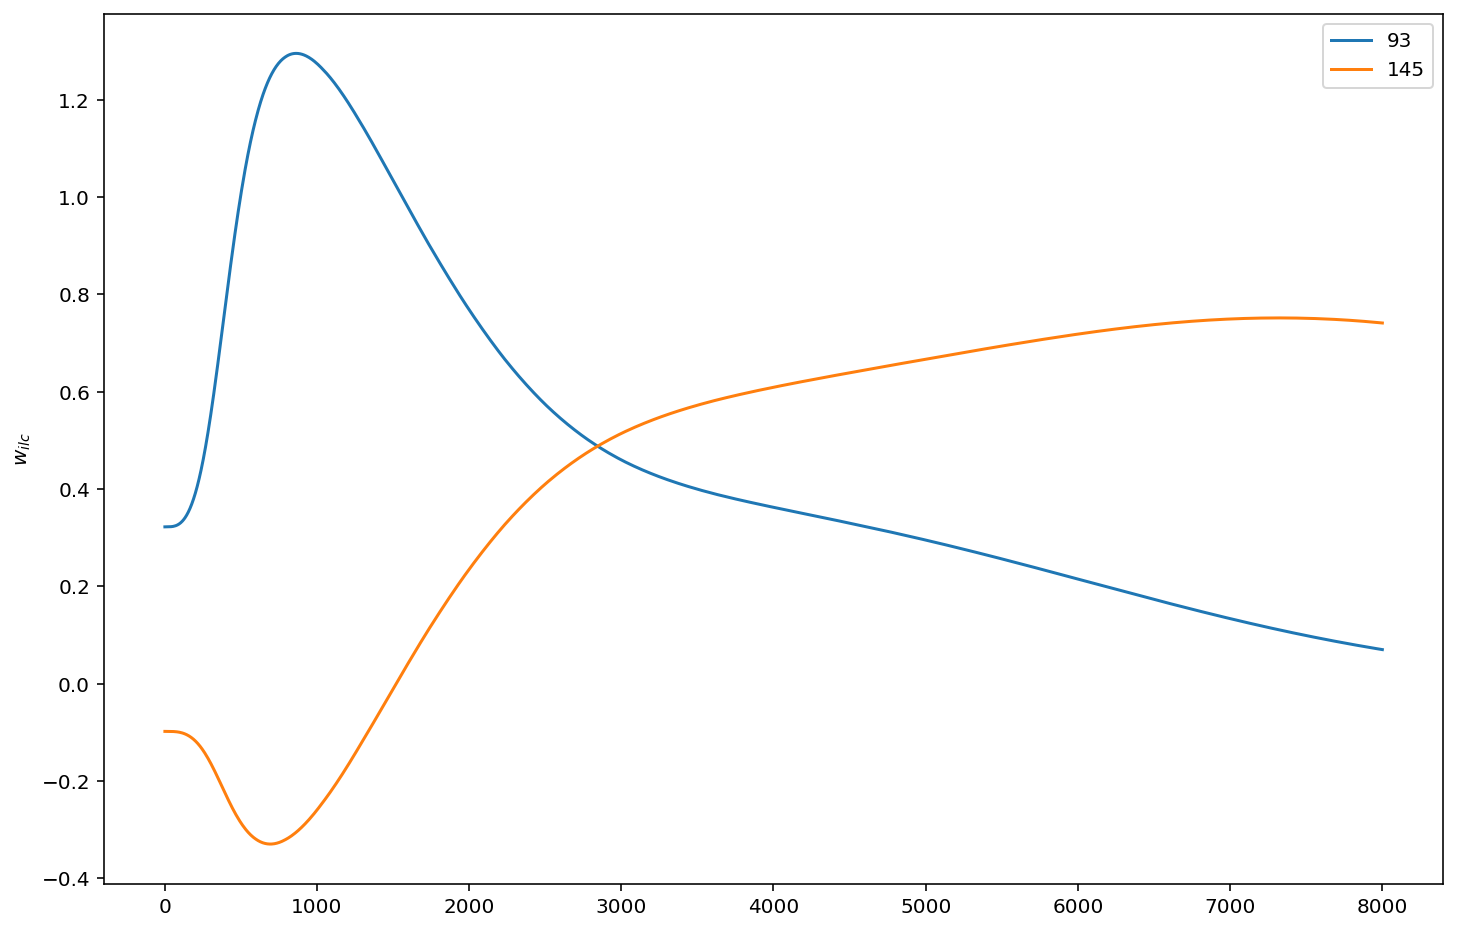

In [108]:
plt.plot(ells, w_ilc_93, label = '93')
plt.plot(ells, w_ilc_145, label = '145')
plt.legend()
plt.ylabel('$w_{ilc}$')

In [115]:
w_ilc = np.loadtxt(path/'w_ilc.txt')
ells, w_ilc_93_145 = w_ilc[:, 0], w_ilc[:, 3:5]

In [117]:
AtSZ = np.array([1, 1.6])
product_ilc_tSZ = np.einsum('...i, i -> ...', w_ilc_93_145, AtSZ)

In [118]:
interpolated_ilc = interp1d(ells, product_ilc_tSZ, kind = 'linear', bounds_error = False, fill_value = 0.)
W_ilc_tSZ_93 = interpolated_ilc(modlmap)

In [120]:
factor = 1.6
rec_fg_map_A = A.reconstruct(fg_fft_masked_A1*W_ilc_tSZ_93, fg_fft_masked_A2*W_ilc_tSZ_93)
rec_fg_gauss_map_A = A.reconstruct(fg_gaussian_fft_masked_A1*W_ilc_tSZ_93, fg_gaussian_fft_masked_A2*W_ilc_tSZ_93)
el, clfg_A_B = Binner.bin_maps(rec_fg_map_A, rec_fg_map_A, pixel_units = True, get_p2d = False)
el, clfg_gauss_A_B = Binner.bin_maps(rec_fg_gauss_map_A, rec_fg_gauss_map_A, pixel_units = True, get_p2d = False)
trispectrum_A_B_93_145_ilc = clfg_A_B-clfg_gauss_A_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [97]:
rec_fg_map_A = Ailc.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)
rec_fg_gauss_map_A = Ailc.reconstruct(fg_gaussian_fft_masked_A1, fg_gaussian_fft_masked_A2)
el, clfg_A_B = Binner.bin_maps(rec_fg_map_A, rec_fg_map_A, pixel_units = True, get_p2d = False)
el, clfg_gauss_A_B = Binner.bin_maps(rec_fg_gauss_map_A, rec_fg_gauss_map_A, pixel_units = True, get_p2d = False)
trispectrum_A_B_ilc = clfg_A_B-clfg_gauss_A_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


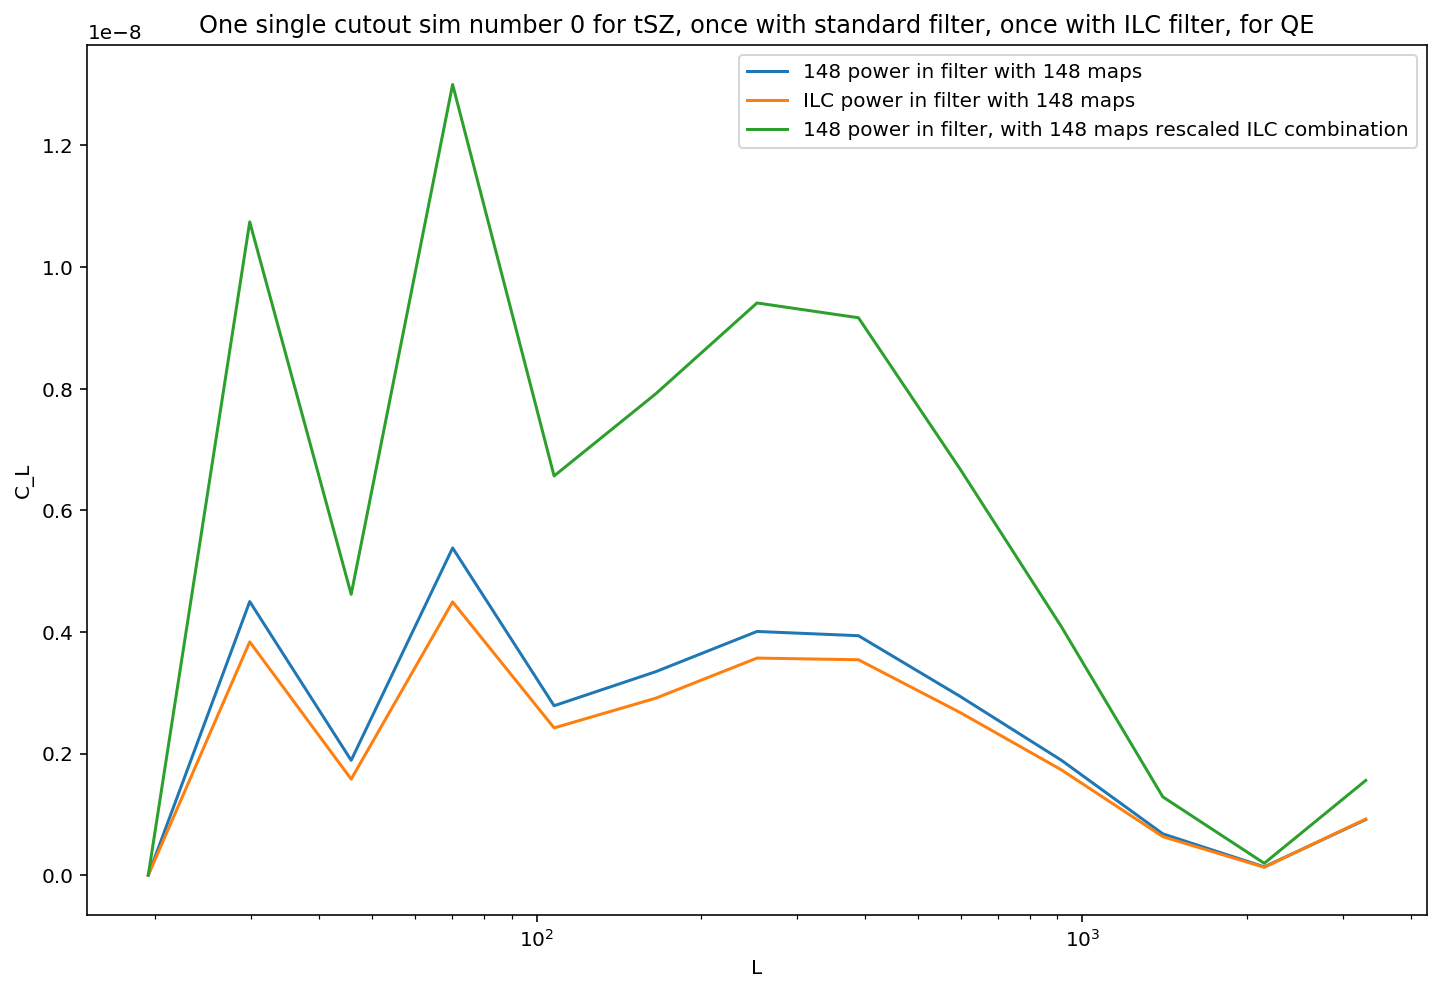

In [124]:
plt.title(f'One single cutout sim number {i} for tSZ, once with standard filter, once with ILC filter, for QE')
plt.plot(el, trispectrum_A_B, label = '148 power in filter with 148 maps')
plt.plot(el, trispectrum_A_B_ilc, label = 'ILC power in filter with 148 maps')
plt.plot(el, trispectrum_A_B_93_145_ilc, label = '148 power in filter, with 148 maps rescaled ILC combination')
plt.xlabel('L')
plt.ylabel('C_L')
plt.xscale('log')
plt.legend()